In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import wget
import re
from scipy.optimize import curve_fit

## Download pickle files for each $n=3,\dots,140$

In [2]:
for i in range(3,141):
    url = "https://www.maths.usyd.edu.au/u/jspreer/results_trials_1000000_nlist_{}".format(i)
    filename = wget.download(url)

100% [................................................................................] 2401 / 2401

## Computation times

In [64]:
with open("log.txt") as file:
    lines = file.readlines()
    
keep = []
for i in range(len(lines)):
    if i % 3 == 0:
        n = int(re.search("[0-9]*:", lines[i]).group()[:-1])
        time = float(re.search("[0-9]*\.[0-9]*", lines[i]).group())
        keep.append((n, time))
        
times = pd.DataFrame(zip(*keep)).T.rename(columns={0:"n", 1:"time"}).sort_values("n")
times["time"] = times["time"] / 60

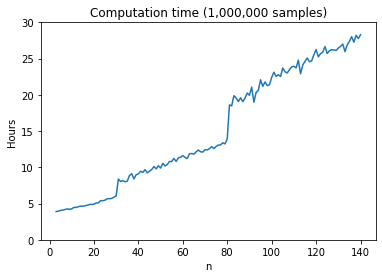

In [3]:
plt.plot(times["n"], times["time"])
plt.ylim([0,30])
plt.title("Computation time (1,000,000 samples)")
plt.xlabel("n")
plt.ylabel("Hours")
plt.show()

## Read in downloaded pickle files

... and stack them into a single pandas data frame. Also process/transform some variables.

In [2]:
# Read and combine data into a single data frame
all_files = glob.glob("results/*")
results_dfs = []

for filename in all_files:
    results_dfs.append(pd.read_pickle(filename))

results = pd.concat(results_dfs, axis=0)
results = results.sort_index()

# Normalise distributions to sum to 1
for n in results.index:
    results.at[n, "distribution"] = [mass / sum(results.loc[n, "distribution"]) for mass in results.loc[n, "distribution"]]
    
# Calculate genus-weighted average symmetries
for n in results.index:
    avg_symmetries = []
    for g in range(int((n-1)/2) + 1):
        if results.loc[n, "avg_symmetries"][g] != None:
            avg_symmetries.append(results.loc[n, "distribution"][g] * results.loc[n, "avg_symmetries"][g])
    
    results.at[n, "avg_symmetries"] = sum(avg_symmetries)

In [3]:
results

,disconnected,distribution,avg_symmetries,avg_var_degree_sequence
3,500243,"[0.666253274080505, 0.33374672591949495]",17.347015,"[15.20316186569435, 0.0]"
4,499707,"[0.7500326127312602, 0.24996738726873974]",13.224425,"[24.049466193626767, 19.99029254222328]"
5,534791,"[0.5654222305363648, 0.34769811223603697, 0.08...",4.863888,"[45.276255766150875, 49.98441172938625, 0.0]"
6,464344,"[0.4625077942899135, 0.44210462787904303, 0.09...",3.96818,"[60.9739672155359, 73.65924425064472, 50.42216..."
7,463705,"[0.3340068255806818, 0.47503336743265834, 0.17...",2.111197,"[82.31238199172437, 105.42371567284488, 107.60..."
...,...,...,...,...
136,70314,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[None, None, None, None, None, None, None, Non..."
137,70781,"[0.0, 0.0, 0.0, 0.0, 3.5788791850343526e-196, ...",1.0,"[None, None, None, None, 72822.10687022899, No..."
138,70234,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[None, None, None, None, None, None, None, Non..."
139,70065,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"[None, None, None, None, None, None, None, Non..."


## Maximum mass

See Figure 4.3 Plot B of the AMSI VRS report.

In [4]:
maxs = []
for n in range(3,141):
    maxs.append(max(results.loc[n, "distribution"]))

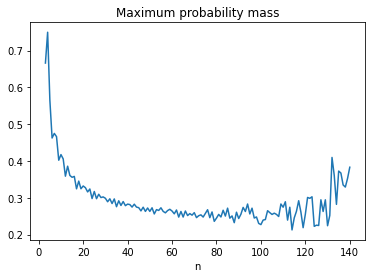

In [5]:
plt.plot(list(range(3,141)), maxs)
plt.title("Maximum probability mass")
plt.xlabel("n")
plt.show()

### Curve fitting attempt

In [60]:
def fit_func(x, a, b, c):
    return np.exp(-a*(x)**(0.6666666)) + b + c*0

params = curve_fit(fit_func, list(range(3,141)), maxs)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


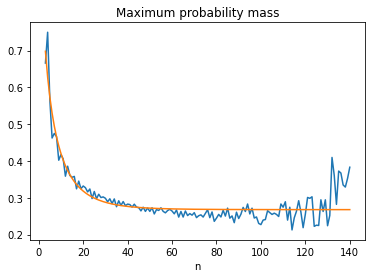

In [62]:
plt.plot(list(range(3,141)), maxs)
plt.plot(list(range(3,141)), fit_func(np.arange(3,141), params[0][0], params[0][1], params[0][2]))
plt.title("Maximum probability mass")
plt.xlabel("n")
plt.show()

### Residual plot

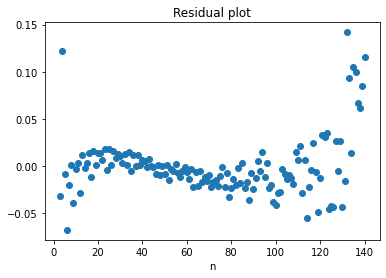

In [63]:
plt.scatter(list(range(3,141)), maxs - fit_func(np.arange(3,141), params[0][0], params[0][1], params[0][2]))
plt.title("Residual plot")
plt.xlabel("n")
plt.show()

## Total mass about $\text{EV}\pm 2$

See Figure 4.3 Plot A of the AMSI VRS report.

In [8]:
c = 2
mass = []
for n in range(3,141):
    ev = 0
    for i in range(len(results.loc[n, "distribution"])):
        ev += i * results.loc[n, "distribution"][i]
    ev = round(ev)
    lower = max(ev - c, 0)
    upper = ev + c
    mass.append(sum(results.loc[n, "distribution"][lower:upper+1]))

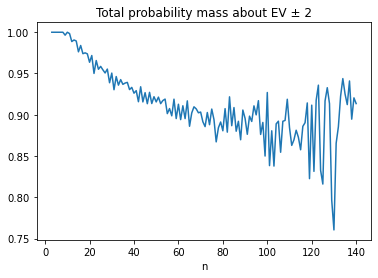

In [22]:
plt.plot(list(range(3,141)), mass)
plt.title("Total probability mass about EV ± 2")
plt.xlabel("n")
plt.show()

## Proportion of subgroups that are intransitive

See Figure 4.6 of the AMSI VRS report.

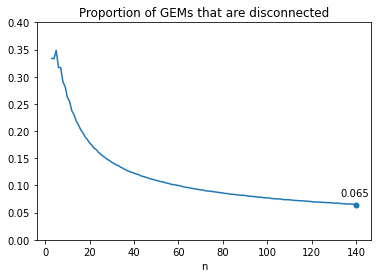

In [11]:
plt.plot(results.index, results["disconnected"] / (1e6+results["disconnected"]))
plt.ylim([0, 0.4])
plt.title("Proportion of GEMs that are disconnected")
plt.xlabel("n")
plt.text(133, 0.08, round(list(results["disconnected"] / (1e6+results["disconnected"]))[-1], 3))
plt.plot(140, list(results["disconnected"] / (1e6+results["disconnected"]))[-1], marker='o', markersize=5, color="C0")
#plt.plot(results.index, 1/(1.28*np.sqrt(results.index)))
plt.show()

## Genus distribution

See Figure 4.2 of the AMSI VRS report.

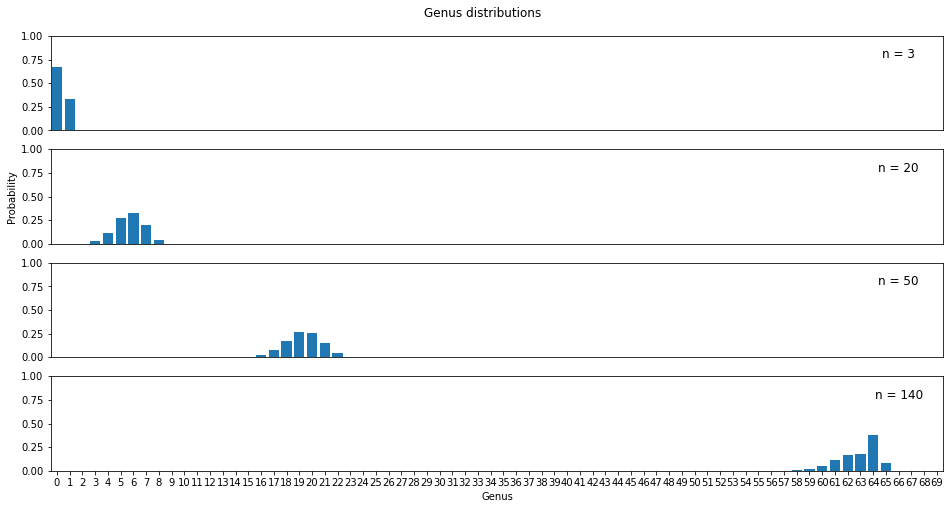

In [3]:
n_list = [3,20,50,140]
fig, ax = plt.subplots(len(n_list), 1, figsize=(16,8))

for i in range(len(n_list)):  
    ax[i].bar(list(range(len(results.loc[n_list[i], "distribution"]))), results.loc[n_list[i], "distribution"])
    ax[i].set_xlim([-0.5, int((n_list[-1]-1)/2) + 0.5])
    ax[i].set_xticks([])
    ax[i].set_ylim([0, 1])
    ax[i].set_title("n = {}".format(n_list[i]), y=0.7, x=0.95)
    
fig.suptitle("Genus distributions", y=0.93)
plt.xticks([i for i in range(int((n_list[-1]-1)/2) + 1)])
plt.xlabel("Genus")
plt.ylabel("Probability", y=2.9)
plt.show()

## Average number of symmetries

See Figure 4.4 and Figure 4.5 of the AMSI VRS report.

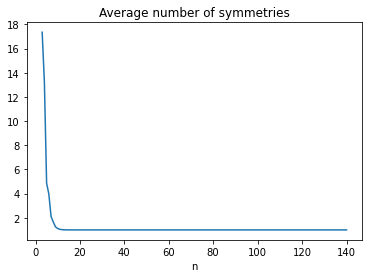

In [18]:
plt.plot(results.index[0:], results["avg_symmetries"][0:])
#plt.ylim([1,20])
plt.title("Average number of symmetries")
plt.xlabel("n")
plt.show()

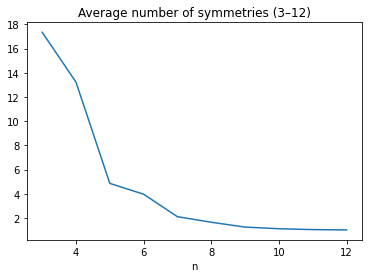

In [19]:
plt.plot(results.index[0:10], results["avg_symmetries"][0:10])
#plt.ylim([1,20])
plt.title("Average number of symmetries (3–12)")
plt.xlabel("n")
plt.show()

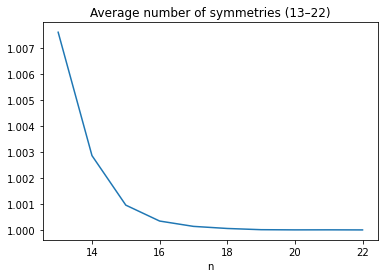

In [20]:
plt.plot(results.index[10:20], results["avg_symmetries"][10:20])
#plt.ylim([1,20])
plt.title("Average number of symmetries (13–22)")
plt.xlabel("n")
plt.show()

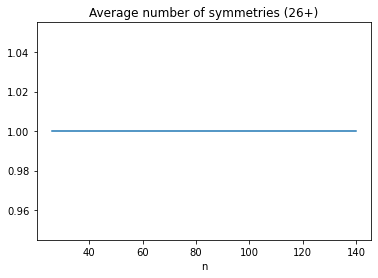

In [21]:
plt.plot(results.index[23:], results["avg_symmetries"][23:])
#plt.ylim([1,20])
plt.title("Average number of symmetries (26+)")
plt.xlabel("n")
plt.show()

## Average sum of squared deviations from average degree

Not included in the AMSI VRS report.

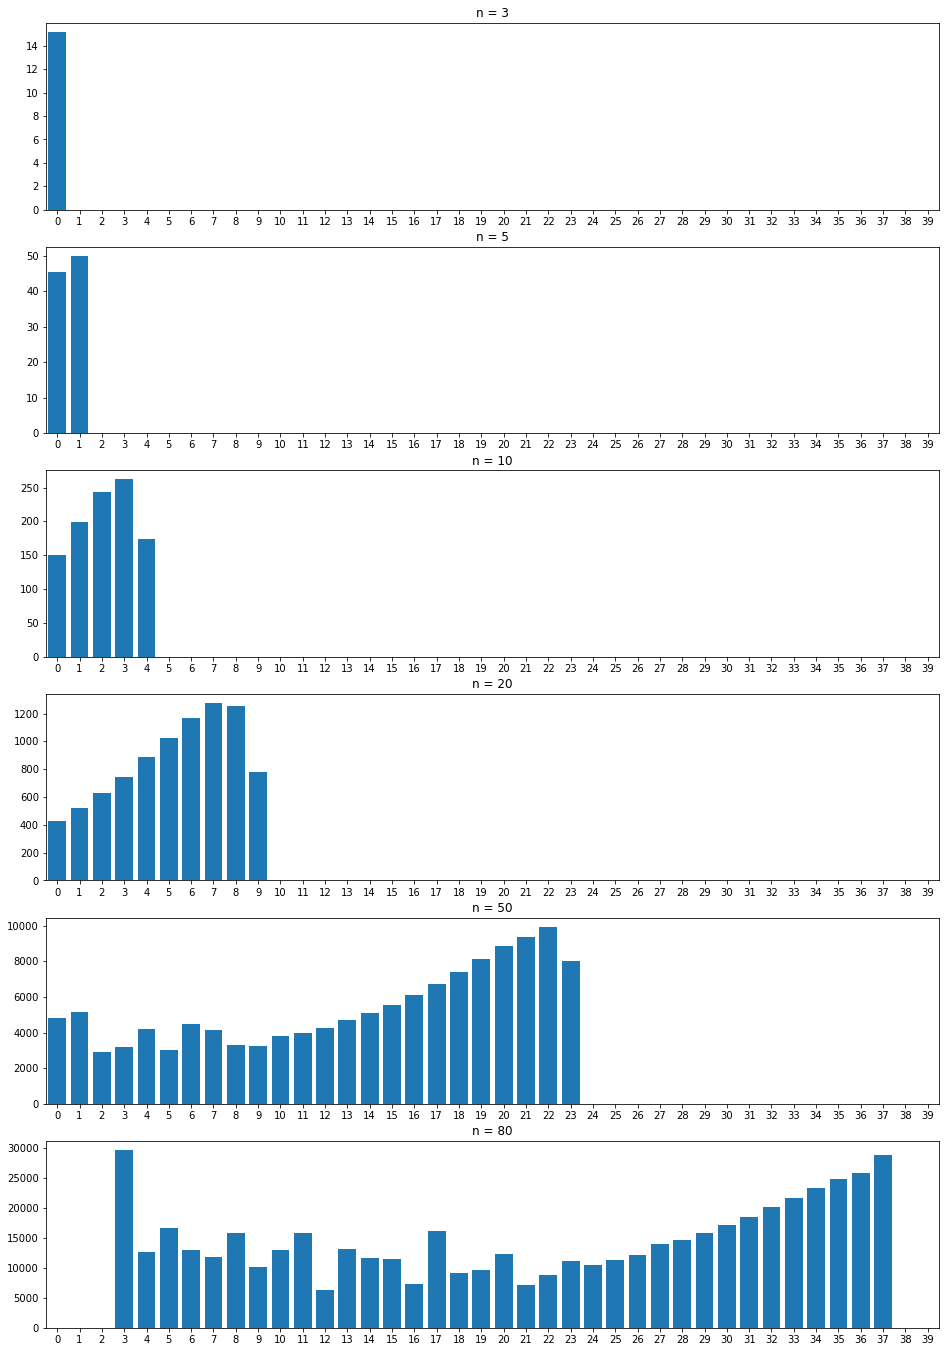

In [129]:
n_list = [3,5,10,20,50,80]
fig, ax = plt.subplots(len(n_list), 1, figsize=(16, 24))

for i in range(len(n_list)): 
    ax[i].bar([g for g in range(int((n_list[i]-1)/2) + 1) if results.loc[n_list[i], "avg_var_degree_sequence"][g] != None],
              [value for value in results.loc[n_list[i], "avg_var_degree_sequence"] if value != None])
    ax[i].set_xlim([-0.5, int((n_list[-1]-1)/2) + 0.5])
    ax[i].set_xticks([i for i in range(int((n_list[-1]-1)/2) + 1)])
    #ax[i].set_ylim([0, 1])
    ax[i].set_title("n = {}".format(n_list[i]))

## Median vs maximum genus
Not included in the AMSI VRS report.

### Ratio

In [43]:
n_list = list(range(6, 81))
medians = {}
maxs = {}
differences = []

for n in n_list:    
    
    li = np.cumsum(results.loc[n, "distribution"]) >= 0.5
    for i in range(len(li)):
        if li[i] == True:
            medians[n] = i
            break

    if n % 2 == 0:
        maxs[n] = (n-2) / 2
    else:
        maxs[n] = (n-1) / 2

    differences.append(maxs[n] / medians[n])

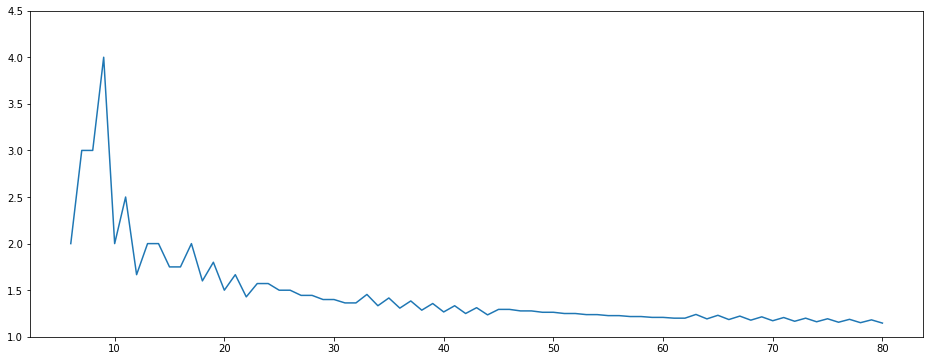

In [47]:
plt.figure(figsize=(16, 6))
plt.plot(n_list, differences)
plt.ylim([1, 4.5])
plt.show()

In [39]:
n_list = list(range(3, 81))
medians = {}
maxs = {}
differences = []

for n in n_list:    
    
    li = np.cumsum(results.loc[n, "distribution"]) >= 0.5
    for i in range(len(li)):
        if li[i] == True:
            medians[n] = i
            break

    if n % 2 == 0:
        maxs[n] = (n-2) / 2
    else:
        maxs[n] = (n-1) / 2

    differences.append(maxs[n] - medians[n])

### Difference

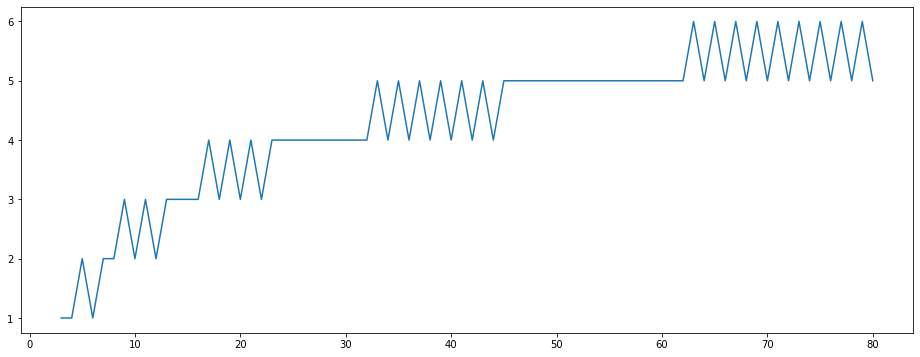

In [40]:
plt.figure(figsize=(16, 6))
plt.plot(n_list, differences)
plt.show()